**kaggle: SNOPKOVSKIY-PV**

#### Задание

По имеющимся данным о стоимости жилой недвижимости (квартир) необходимо создать модель машинного обучения, способную предсказывать стоимость похожих объектов с точностью не хуже R2 - коэффициент детерминации (sklearn.metrics.r2_score) = 0.6

**Описание датасета**

Статистические данные о стоимости квартир в разных районах города

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Содержание

1. [Загрузка данных, оптимизация ресурсов](#step1) </n>
2. [Обзор целевой переменной](#step2)
3. [Обзор количественных переменных](#step3)
4. [Обзор номинативных переменных](#step4)
5. [Обработка пропусков](#step5)
6. [Линейные связи с целевой переменной](#step6)
7. [Feature engineering](#step7)
8. [Разбиение на выборки (обучающую и тестовую)](#step8)
9. [Моделирование](#step9)
10. [Прогнозирование на тестовом наборе](#step10)

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import datetime
from scipy.stats import mode
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.ensemble import GradientBoostingRegressor

# 4. Метрики качества
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 10})

**Пути к директориям и файлам**

In [3]:
train_path = './moscow/train.csv'
test_path = './moscow/test.csv'

# <a id="step1">Загрузка данных, оптимизация ресурсов</a>

In [4]:
# Функция оптимизации ресурсов памяти, занимаемой датасетами

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
# оптимизация памяти на трейне 
x_train = pd.read_csv(train_path, sep=',')
x_train = reduce_mem_usage(x_train)
df_train = x_train.copy()
x_train.head(7)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
5,5804,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.937500
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.734375


In [6]:
# проверка типов после оптимизации
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [7]:
# оптимизация памяти на тесте
x_test = pd.read_csv(test_path, sep=',')
df_test = reduce_mem_usage(x_test)
x_test = df_test.copy()
x_test.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
df_train.shape

(10000, 20)

In [9]:
df_test.shape

(5000, 19)

# <a id="step2">Обзор целевой переменной</a>

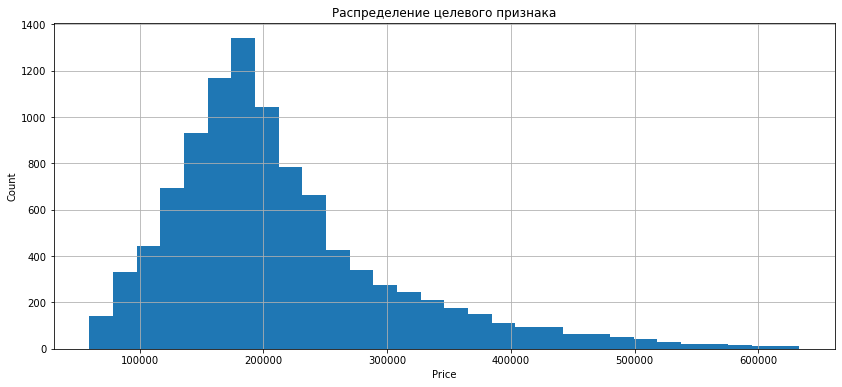

In [10]:
plt.figure(figsize = (14, 6))

df_train['Price'].hist(bins = 30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Распределение целевого признака')
plt.show()

Распределение целевой переменной в целом похоже на нормальное. Есть правый хвост, свидетельствующий о наличии в выборке очень дорогих объектов, что не противоречит представлениям о рынке недвижимости

# <a id="step3">Обзор количественных переменных</a>

In [11]:
# перевод id в категорию
df_train[['Id', 'DistrictId']] = df_train[['Id', 'DistrictId']].astype('category')

In [12]:
df_train_num_features = df_train.select_dtypes(include=['float32', 'int8', 'int16', 'int'])
df_train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750


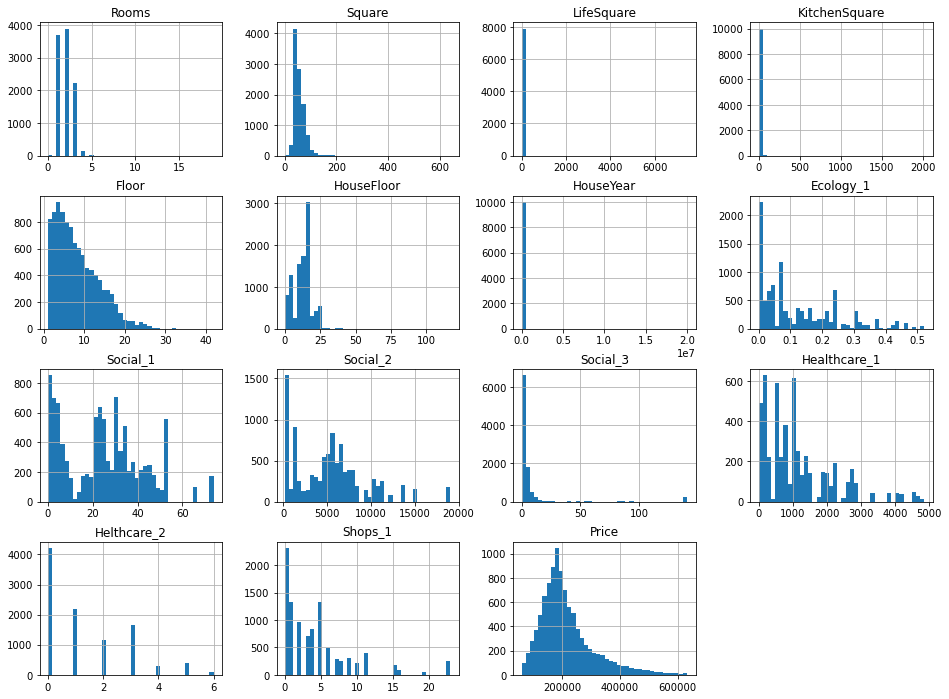

In [13]:
# графическая интерпретация распределения значений в числовых признаках
df_train_num_features.hist(figsize = (16,12), bins = 40)
plt.show()

In [14]:
# статистики
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [16]:
# количество комнат - где 0 меняем на 1 и больше 6 - меняем на моду
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6), 'Rooms_outlier'] = 1

In [18]:
df_train.loc[df_train['Rooms'] ==  0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] > 6, 'Rooms'] = df_train['Rooms'].mode()[0]

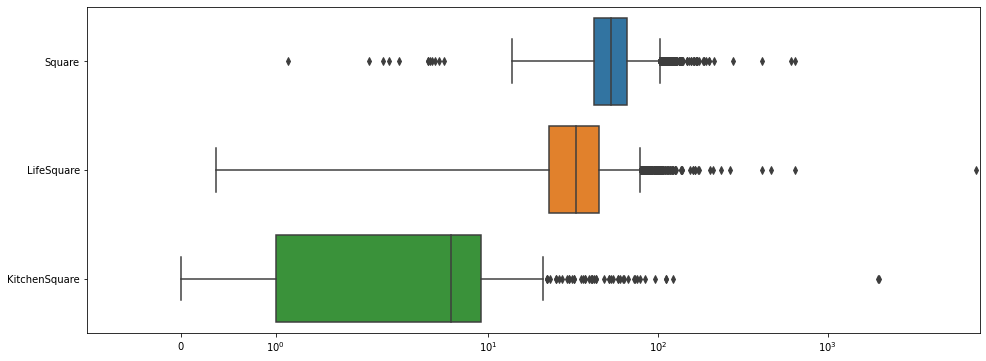

In [19]:
# построим ящик с усами для всех признаков с площадями, чтобы лучше увидеть аномалии
plt.figure(figsize=(16, 6))
sns.boxplot(data = df_train[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

In [20]:
# общая площадь - при площади менее 1.5м умножаем на 100, менее 15м умножаем на 10, более 250м - делим на 10
cnt = len(df_train.loc[(df_train['Square'] < 15) | (df_train['Square'] > 250)])
print(f'Количество аномальных строк: {cnt}')
df_train.loc[df_train['Square'] < 1.5, 'Square'] = df_train['Square'] * 100
df_train.loc[df_train['Square'] < 15, 'Square'] = df_train['Square'] * 10
df_train.loc[df_train['Square'] > 250, 'Square'] = df_train['Square'] / 10
df_train['Square'].describe()

Количество аномальных строк: 17


count    10000.000000
mean        56.204556
std         18.972906
min         16.117155
25%         41.784624
50%         52.519197
75%         65.890818
max        212.932358
Name: Square, dtype: float64

In [21]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [22]:
# в жилой площади: нашли медиану доли жилой недвижимости к общей недвижимости там, где жилая площадь меньше общей площади,
# c учетом этой доли обновили аномальные значения в случаях, когда жилая площадь почему-то больше общей площади
square_share = (df_train.loc[df_train['LifeSquare'] < df_train['Square'], 
                    'LifeSquare'] / df_train.loc[df_train['LifeSquare'] < df_train['Square'], 'Square']).median()
df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['Square'] * square_share

In [23]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       34.534252
std        15.862592
min         0.370619
25%        22.676733
50%        32.052044
75%        43.770905
max       211.231125
Name: LifeSquare, dtype: float64

In [24]:
# площадь кухни - там, где площадь кухни больше общей площади - берем общую площадь
df_train.loc[df_train['KitchenSquare'] > df_train['Square'], 'KitchenSquare'] = df_train['Square']

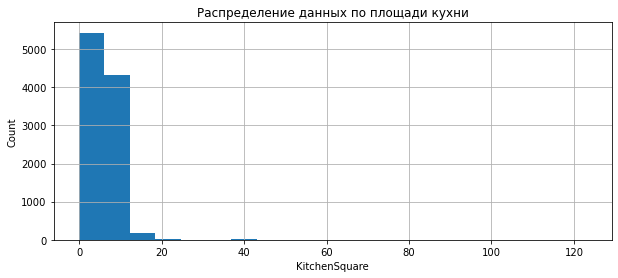

In [25]:
plt.figure(figsize = (10, 4))

df_train['KitchenSquare'].hist(bins = 20)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.title('Распределение данных по площади кухни')
plt.show()

In [26]:
# весь правый хвост распределения - выбросы. Заменим их на медиану. Площадь кухни, равная нулю, может быть ошибкой в данных, но
# может говорить о квартире-студии. В любом случае в квартире есть место с ролью кухни - для нулевых значений сделаем значение
# площади кухни, равное 3
condition = df_train[df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975)]
df_train.loc[condition.index, 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.238200
std          2.794661
min          3.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

In [28]:
# проверим, что этаж квартиры сопоставим с этажностью дома - видим много выбросов
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [29]:
# сделаем дополнительный признак, характеризующий наличие выброса в этаже квартиры и этажности дома
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [30]:
# заполним значения, где этажность дома равна нулю значениями медианы по этому признаку, а случаи, когда этаж квартиры больше
# этажа дома - произвольным значением в пределах этажности дома
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [31]:
# год постройки дома - заменяем выбросы на моду, меняем фичу на возраст дома
year = datetime.datetime.today().year
df_train['HouseYear_outlier'] = 0
df_train.loc[df_train['HouseYear'] > year, 'HouseYear_outlier'] = 1

df_train.loc[df_train['HouseYear'] >  year, 'HouseYear'] = df_train['HouseYear'].mode()[0]
df_train['House_age'] = year - df_train['HouseYear']
df_train = df_train.drop(['HouseYear'], axis = 1 )

# <a id="step4">Обзор номинативных переменных</a>

In [32]:
df_train_obj_features = df_train.select_dtypes(include='category')
df_train_obj_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B


In [33]:
# категориальные признаки характеризуются малой вариативностью значений
for column in df_train_obj_features.columns[2:]:
    print(df_train_obj_features[column].value_counts(), '\n')

B    9903
A      97
Name: Ecology_2, dtype: int64 

B    9725
A     275
Name: Ecology_3, dtype: int64 

B    9175
A     825
Name: Shops_2, dtype: int64 



# <a id="step5">Обработка пропусков</a>

In [34]:
df_train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
House_age                0
dtype: int64

In [35]:
# LifeSquare - заполним пропуски с использованием медианы доли жилой площади к общей площади по объектам без пропусков, добавив
# предварительно столбец с указанием на наличие пропуска в данных
df_train['LifeSquare_nan'] = 0
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [36]:
df_train[df_train['LifeSquare_nan'] == 0]['Square'].describe()

count    7887.000000
mean       55.162262
std        18.683817
min        16.117155
25%        41.182070
50%        50.873131
75%        64.698078
max       212.932358
Name: Square, dtype: float64

In [37]:
share = round((df_train[df_train['LifeSquare_nan'] == 0]['LifeSquare'] / 
               df_train[df_train['LifeSquare_nan'] == 0]['Square']).median(), 2)
df_train['LifeSquare'] = df_train['LifeSquare'].fillna(df_train['Square'] * share)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,House_age,LifeSquare_nan
0,11809,27,3.0,115.027313,70.166664,10.0,4,10.0,0.075424,B,...,NaN,0,0,B,305018.875000,0,0,0,8,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,0.118537,B,...,1183.0,1,0,B,177734.546875,0,0,0,56,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,0.025609,B,...,240.0,3,1,B,282078.718750,0,0,0,34,0
3,2352,1,1.0,40.409908,24.650045,3.0,10,22.0,0.007122,B,...,NaN,0,1,B,168106.000000,0,0,0,45,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,0.282798,B,...,NaN,0,6,B,343995.093750,0,0,0,50,0


In [38]:
# Healthcare_1
df_train['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [39]:
# добавим дополнительный признак, указывающий на наличие пропуска в изучаемом признаке
df_train['Healthcare_1_nan'] = 0
df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [40]:
# оценим вариативность признака
df_train['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [41]:
# посмотрим, что общего у объектов с одинаковым значением признака 'Healthcare_1' - это одинаковый район города ('DistrictId')
df_train[df_train['Healthcare_1'] == 540]['DistrictId'].value_counts()

6      511
209      0
64       0
74       0
73       0
      ... 
133      0
132      0
131      0
130      0
0        0
Name: DistrictId, Length: 205, dtype: int64

In [42]:
# заполним пропуски по 'Healthcare_1' с учетом района города
df_train = df_train.sort_values(by = 'DistrictId')
df_train['Healthcare_1'].fillna(method ='pad', inplace = True)

In [43]:
df_train.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
House_age             0
LifeSquare_nan        0
Healthcare_1_nan      0
dtype: int64

# <a id="step6">Линейные связи с целевой переменной</a>

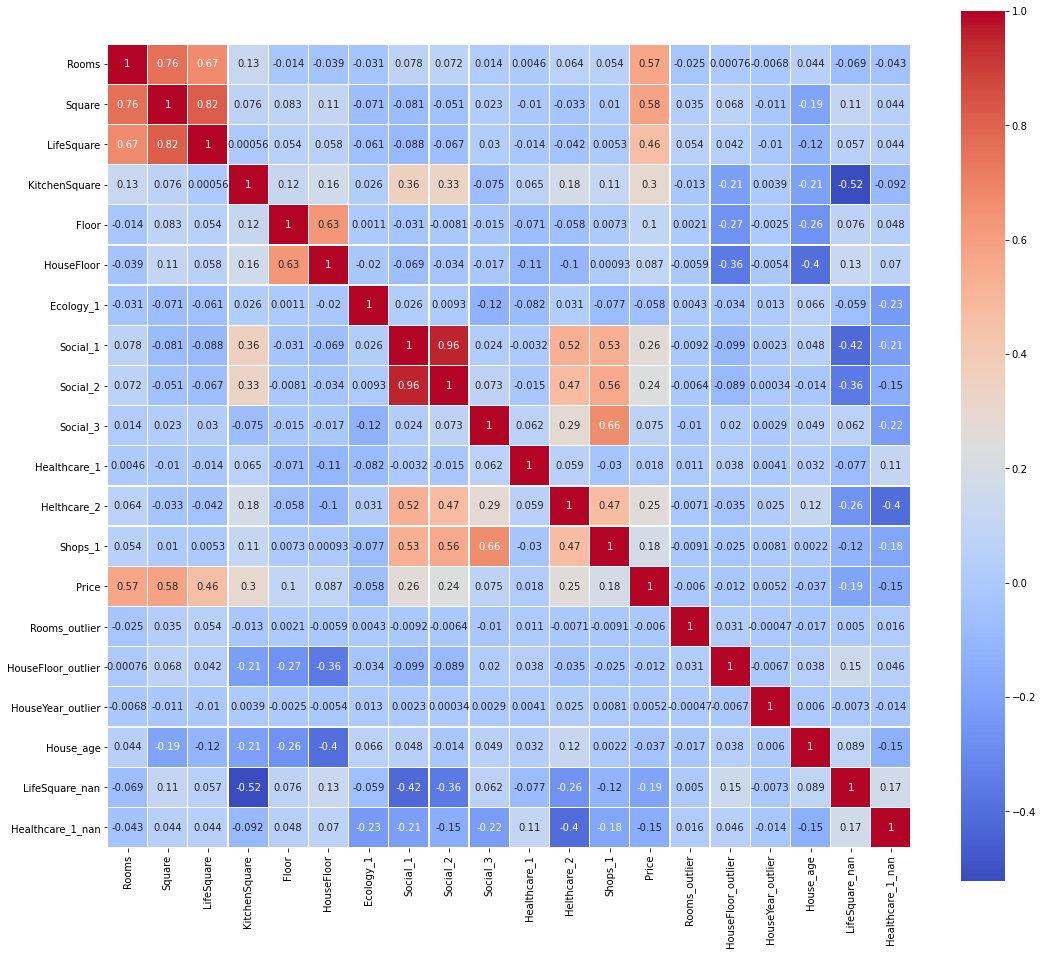

In [44]:
# построим матрицу корреляций
df_corr = df_train.corr()
plt.figure(figsize = (18, 16))
sns.heatmap(df_corr, annot = True, linewidths = 0.3, cmap = 'coolwarm', square = True)
plt.show()

Как видно, наибольшее линейное влияние из числовых признаков на целевую переменную оказывает количество комнат, общая площадь объекта, жилая площадь. 

In [45]:
# оформим в виде класса ранее сделанные шаги при препроцессинге данных
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.modes = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        # Расчет мод
        self.modes = X.mode()[:1]
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Id's typing
        X[['Id', 'DistrictId']] = X[['Id', 'DistrictId']].astype('category')

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.modes['Rooms'][0]
        
        # Square    
        X.loc[X['Square'] < 1.5, 'Square'] = X['Square'] * 100
        X.loc[X['Square'] < 15, 'Square'] = X['Square'] * 10
        X.loc[X['Square'] > 250, 'Square'] = X['Square'] / 10
        
        # LivingSquare
        square_share = (X.loc[X['LifeSquare'] < X['Square'], 
                    'LifeSquare'] / X.loc[X['LifeSquare'] < X['Square'], 'Square']).median()
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] * square_share     
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = X['Square']
        
        condition = X[X['KitchenSquare'] > self.kitchen_square_quantile]
        X.loc[condition.index, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
               
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        year = datetime.datetime.today().year
        
        X['HouseYear_outlier'] = 0
        
        X.loc[X['HouseYear'] > year, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] >  year, 'HouseYear'] = self.modes['HouseYear'][0]
        X['House_age'] = year - X['HouseYear']
               
        # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        
        X = X.sort_values(by = 'DistrictId')
        X['Healthcare_1'].fillna(method ='pad', inplace = True)
            
        # LifeSquare        
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        
        share = round((X[X['LifeSquare_nan'] == 0]['LifeSquare'] / 
               X[X['LifeSquare_nan'] == 0]['Square']).median(), 2)

        X['LifeSquare'] = X['LifeSquare'].fillna(X['Square'] * share)
        
        
        return X


# <a id="step7">Feature engineering</a>

In [46]:
# категории с бинарными значениями
to_binary = ['Ecology_2', 'Ecology_3', 'Shops_2']
binary_dict = {'A': 0, 'B': 1}
for column in to_binary:
    df_train[column] = df_train[column].replace(binary_dict)

In [47]:
# добавим признак, характеризующий частоту встречаемости района
size = df_train['DistrictId'].value_counts().reset_index().rename(columns = {'index' : 'DistrictId', 'DistrictId' : 'DistSize'})
df_train = df_train.merge(size, on = 'DistrictId', how = 'left')
df_train['is_BigDist'] = (df_train['DistSize'] > 100).astype(int)

In [48]:
df_train['is_BigDist'].value_counts()

1    5069
0    4931
Name: is_BigDist, dtype: int64

In [49]:
def floor_to_cat(X):
    """Функция перевода этажа квартиры в категорию(группу)"""

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 7), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 7) & (X['Floor'] <= 11), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 11) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def year_to_cat(X):
    """Функция перевода возраста дома в категорию(группу)"""
    X['year_cat'] = 0

    X.loc[X['House_age'] <= 10, 'year_cat'] = 1
    X.loc[(X['House_age'] > 10) & (X['House_age'] <= 15), 'year_cat'] = 2
    X.loc[(X['House_age'] > 15) & (X['House_age'] <= 25), 'year_cat'] = 3
    X.loc[(X['House_age'] > 25) & (X['House_age'] <= 40), 'year_cat'] = 4
    X.loc[(X['House_age'] > 40) & (X['House_age'] <= 50), 'year_cat'] = 5
    X.loc[(X['House_age'] > 50), 'year_cat'] = 6

    return X

In [50]:
df_train = floor_to_cat(df_train)
df_train = year_to_cat(df_train)

In [51]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,House_age,LifeSquare_nan,Healthcare_1_nan,DistSize,is_BigDist,floor_cat,year_cat
0,16536,0,1.0,31.114313,24.076126,4.0,1,9.0,0.319809,1,...,0,0,0,57,0,0,48,0,1,6
1,2484,0,3.0,70.322746,45.465961,10.0,8,12.0,0.319809,1,...,0,0,0,46,0,0,48,0,3,5
2,2426,0,1.0,33.237858,21.761829,7.0,5,9.0,0.319809,1,...,0,0,0,51,0,0,48,0,2,6
3,14492,0,2.0,62.962154,37.043240,10.0,10,22.0,0.319809,1,...,0,0,0,15,0,0,48,0,3,2
4,14295,0,1.0,46.556293,21.118280,10.0,8,19.0,0.006076,1,...,0,0,0,10,0,0,48,0,3,1


In [52]:
# оформим в виде класса ранее сделланные шаги
class FeatureCreator():
    """Добавление новых признаков"""
    
    def __init__(self):
        self.size = None
        self.binary_dict = None
        self.mean_price_by_dist = None
        self.mean_price_by_year_floor = None     
        
        
    def fit(self, X, y = None):
        
        # Binary features
        self.binary_dict = {'A': 0, 'B': 1}
        
        # DistrictID
        self.size = X['DistrictId'].value_counts().reset_index().rename(
                                columns = {'index' : 'DistrictId', 'DistrictId' : 'DistSize'})
        
    def transform(self, X):

        # Binary features        
        to_binary = ['Ecology_2', 'Ecology_3', 'Shops_2']
        for column in to_binary:
            X[column] = X[column].replace(self.binary_dict)
       
        # DistrictId, IsDistrictLarge
        X = X.merge(self.size, on = 'DistrictId', how = 'left')     
        
        X['new_district'] = 0
        X.loc[X['DistSize'].isna(), 'new_district'] = 1
        
        X['DistSize'].fillna(10, inplace=True)
        
        X['is_BigDist'] = (X['DistSize'] > 100).astype(int)

        # More categorical features
        X = self.floor_to_cat(X) 
        X = self.year_to_cat(X)  
      
        return X
    
    
    def floor_to_cat(self, X):

        X['floor_cat'] = 0
        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 7), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 7) & (X['Floor'] <= 11), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 11) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        X['floor_cat'].fillna(-1, inplace=True)

        return X   
    
    def year_to_cat(self, X):
        
        X['year_cat'] = 0
        X.loc[X['House_age'] <= 10, 'year_cat'] = 1
        X.loc[(X['House_age'] > 10) & (X['House_age'] <= 15), 'year_cat'] = 2
        X.loc[(X['House_age'] > 15) & (X['House_age'] <= 25), 'year_cat'] = 3
        X.loc[(X['House_age'] > 25) & (X['House_age'] <= 40), 'year_cat'] = 4
        X.loc[(X['House_age'] > 40) & (X['House_age'] <= 50), 'year_cat'] = 5
        X.loc[(X['House_age'] > 50), 'year_cat'] = 6
        X['year_cat'].fillna(-1, inplace=True)
    
        return X

In [53]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'House_age']

new_features = ['Rooms_outlier', 'HouseFloor_outlier','HouseYear_outlier',
        'LifeSquare_nan', 'Healthcare_1_nan', 'DistSize',
       'is_BigDist', 'floor_cat', 'year_cat']

target = ['Price']

# <a id="step8">Разбиение на выборки (обучающую и тестовую)</a>

In [54]:
# разбиение обучающей выборки на подвыборки
X = x_train.drop(columns = target)
y = x_train[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 13)

In [55]:
# предобработка подвыборок
preprocessing = DataPreprocessing()
preprocessing.fit(X_train)

X_train = preprocessing.transform(X_train)
X_valid = preprocessing.transform(X_valid)

X_train = X_train.sort_index()
X_valid = X_valid.sort_index()
y_train = y_train.sort_index()
y_valid = y_valid.sort_index()

X_train.shape, X_valid.shape

((7000, 25), (3000, 25))

In [56]:
# добавление новых фичей в выборки
creating = FeatureCreator()
creating.fit(X_train, y_train)

X_train = creating.transform(X_train)
X_valid = creating.transform(X_valid)

X_train.shape, X_valid.shape

((7000, 30), (3000, 30))

In [57]:
df_temp = X_train.merge(x_train, on = 'Id', how = 'left')
y_train = df_temp['Price']
df_temp = X_valid.merge(x_train, on = 'Id', how = 'left')
y_valid = df_temp['Price']

In [58]:
# отбор признаков для обучения
feat_to_model = features + new_features
X_train = X_train[feat_to_model]
X_valid = X_valid[feat_to_model]

# <a id="step9">Моделирование</a>

In [59]:
def take_predictions(train_true, train_pred, valid_true, valid_pred):
    """Функция расчета метрик и визуализации результата"""
    
    print("R2 on train:\t" + str(round(r2_score(train_true, train_pred), 4)))
    print("R2 on valid:\t" + str(round(r2_score(valid_true, valid_pred), 4)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred, y = train_true)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Predictions on TRAIN')
    
    plt.subplot(122)
    sns.scatterplot(x = valid_pred, y = valid_true)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Predictions on VALID')

    plt.show()

In [60]:
# обучение модели
gbr_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=13, alpha=0.6)
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.6, n_estimators=150, random_state=13)

In [61]:
# предсказание
y_train_preds = gbr_model.predict(X_train)
y_test_preds = gbr_model.predict(X_valid)

R2 on train:	0.7902
R2 on valid:	0.7284


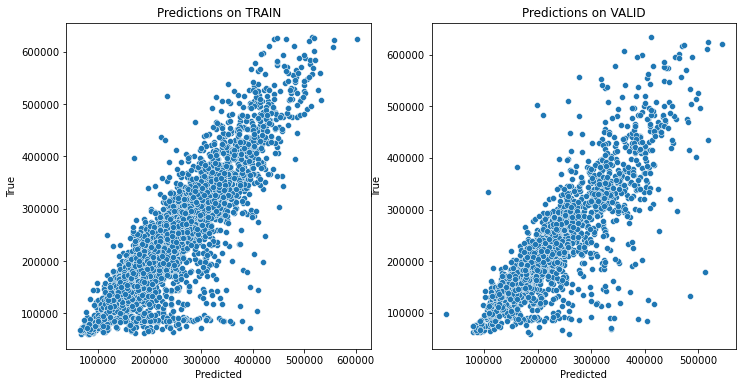

In [62]:
# вывод метрик
take_predictions(y_train, y_train_preds, y_valid, y_test_preds)

In [63]:
# кросс-валидация
cv_score = cross_val_score(gbr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=13))
cv_score.mean().round(3)

0.715

In [64]:
# оценка важности признаков
feature_importances = pd.DataFrame(index = X_train.columns, data = gbr_model.feature_importances_, 
                                   columns = ['importance']).sort_values(by = 'importance', ascending = False)
feature_importances.head(10)

,importance
Square,0.505648
DistSize,0.225547
Social_3,0.048993
Social_2,0.042499
Rooms,0.028109
Social_1,0.027803
House_age,0.020770
Ecology_1,0.020395
HouseFloor,0.017280
is_BigDist,0.013906


# <a id="step10">Прогнозирование на тестовом наборе</a>

In [65]:
preprocessing = DataPreprocessing()
preprocessing.fit(x_test)
x_test = preprocessing.transform(x_test)
x_test = x_test.sort_index()

In [66]:
creating = FeatureCreator()
creating.fit(x_test)

x_test = creating.transform(x_test)

x_test.shape

(5000, 30)

In [67]:
x_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,House_age,Healthcare_1_nan,LifeSquare_nan,DistSize,new_district,is_BigDist,floor_cat,year_cat
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970.0,0.036122,...,0,0,52.0,0,0,46,0,0,2,6
1,5925,62,1.0,42.493908,26.016420,10.0,7,17.0,2017.0,0.072158,...,0,0,5.0,1,0,122,0,1,2,1
2,960,27,2.0,59.463676,36.272842,9.0,19,19.0,1977.0,0.211401,...,0,0,45.0,1,1,391,0,1,5,5
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965.0,0.014073,...,0,0,57.0,1,0,264,0,1,1,6
4,746,74,1.0,53.837055,32.840603,3.0,8,17.0,1977.0,0.309479,...,0,0,45.0,0,1,61,0,0,3,5


In [68]:
ids = x_test['Id']
feat_to_model = features + new_features
x_test = x_test[feat_to_model]

In [69]:
y_test_preds = gbr_model.predict(x_test)

In [70]:
# подготовка результата на тестовой выборке
submit = pd.DataFrame(data = ids)
submit['Price'] = y_test_preds

In [71]:
submit.head()

,Id,Price
0,4567,155962.504219
1,5925,141171.904835
2,960,169306.774327
3,3848,115605.596109
4,746,226911.931437


In [72]:
# запись в файл
submit.to_csv('gbr_submit.csv', index=False)